In [27]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K
import keras
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
%matplotlib inline

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
data_path = "/content/drive/MyDrive/Timeseries_test/big_alldata.csv"
df_use = pd.read_csv(data_path)

In [30]:
df_use.columns

Index(['0', 'PM_Routine', 'Routine_Routine', 'General_Routine',
       'OVERHAUL_Routine', 'PdM_Routine', 'CFT_Routine', 'CM_Non-Routine',
       'REC_Non-Routine', 'MoD_Non-Routine', 'PM_Routine_WORK_NOT_DONE',
       'Routine_Routine_WORK_NOT_DONE', 'General_Routine_WORK_NOT_DONE',
       'OVERHAUL_Routine_WORK_NOT_DONE', 'PdM_Routine_WORK_NOT_DONE',
       'CFT_Routine_WORK_NOT_DONE', 'CM_Non-Routine_WORK_NOT_DONE',
       'REC_Non-Routine_WORK_NOT_DONE', 'MoD_Non-Routine_WORK_NOT_DONE',
       'All_Non-Routine_WORK_NOT_DONE', 'PM_Routine_WORK_DONE',
       'Routine_Routine_WORK_DONE', 'General_Routine_WORK_DONE',
       'OVERHAUL_Routine_WORK_DONE', 'PdM_Routine_WORK_DONE',
       'CFT_Routine_WORK_DONE', 'CM_Non-Routine_WORK_DONE',
       'REC_Non-Routine_WORK_DONE', 'MoD_Non-Routine_WORK_DONE',
       'All_Non-Routine_WORK_DONE', 'PM_Routine_DAY_NOT_DONE',
       'Routine_Routine_DAY_NOT_DONE', 'General_Routine_DAY_NOT_DONE',
       'OVERHAUL_Routine_DAY_NOT_DONE', 'PdM_Routine_D

In [31]:
df_use['All_Non-Routine'] = df_use['CM_Non-Routine'] + df_use['REC_Non-Routine'] + df_use['MoD_Non-Routine']

In [32]:
df_use['All_Non-Routine_DAY_DONE'] = df_use['CM_Non-Routine_DAY_DONE'] + df_use['REC_Non-Routine_DAY_DONE'] + df_use['MoD_Non-Routine_DAY_DONE']

In [33]:
def get_data(df_use):
  df_use = df_use.rename(columns = {'0':'Date'})
  col = ['Date','PM_Routine','General_Routine','All_Non-Routine']
  extension = ['_WORK_NOT_DONE','_WORK_DONE','_DAY_NOT_DONE','_DAY_DONE']

  col_ex = []
  for e in extension:
      col_ex.append(col[3] + e)
  col += col_ex
  df = df_use[col]
  df['Date']= pd.to_datetime(df['Date'])
  # df = df[(df['Date'] <= '2021-12-12') & (df['Date'] >= '2017-07-01')]
  df = df.reset_index(drop=True)
  time = df.iloc[:,0]
  df = df.iloc[:,1:]
  return time, df

In [34]:
time_df,df = get_data(df_use)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [35]:
df

,PM_Routine,General_Routine,All_Non-Routine,All_Non-Routine_WORK_NOT_DONE,All_Non-Routine_WORK_DONE,All_Non-Routine_DAY_NOT_DONE,All_Non-Routine_DAY_DONE
0,0.202313,0.000000,0.000000,0.000000,0.0,230.0,0.0
1,4.957640,0.000000,0.000000,0.000000,0.0,229.0,1.0
2,4.957640,0.000000,0.000000,0.000000,0.0,228.0,2.0
3,4.979667,0.000000,0.000000,0.000000,0.0,227.0,3.0
4,4.979667,0.000000,2.142857,69.857143,0.0,373.0,4.0
...,...,...,...,...,...,...,...
2933,20.000000,15.086207,0.000000,0.000000,0.0,0.0,0.0
2934,41.000000,15.086207,0.000000,0.000000,0.0,0.0,0.0
2935,20.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2936,20.000000,21.000000,1.000000,0.000000,0.0,0.0,0.0


In [ ]:
df_all = df["All_Non-Routine"].to_list()

In [ ]:
df = df[:-30]

In [ ]:
df["All_Non-Routine"] = df_all[30:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
n = len(df)
x_train = df[0:int(n*0.7)]
x_valid = df[int(n*0.7):int(n*0.9)]
x_test = df[int(n*0.9):]
time_train = time_df[0:int(n*0.7)]
time_valid = time_df[int(n*0.7):int(n*0.9)]
time_predict = time_df[int(n*0.9):]

mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean)/std
x_valid = (x_valid - mean)/std
x_test = (x_test - mean)/std

In [ ]:
print(n)

2908


In [ ]:
x_train.columns

Index(['PM_Routine', 'General_Routine', 'All_Non-Routine',
       'All_Non-Routine_WORK_NOT_DONE', 'All_Non-Routine_WORK_DONE',
       'All_Non-Routine_DAY_NOT_DONE', 'All_Non-Routine_DAY_DONE'],
      dtype='object')

In [ ]:
class WindowGenerator():
    def __init__(self, train_df, val_df, test_df,input_features, 
                 label_features, input_width, label_width, shift=0):
        # Store the raw data.
        # self.train_df = train_df
        # self.val_df = val_df
        # self.test_df = test_df
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        print(self.train_df.columns)

        self.input_features=input_features
        self.label_features=label_features

        self.indices_features = {name: i for i, name in
                            enumerate(self.train_df.columns)}
        # self.indices_features = input_features
        # Work out the label column indices.


        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift + label_width


        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        label_start = input_width + shift
        self.label_slice = slice(label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]

    def split_window(self, features):
        # print(features)
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        
        inputs = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.input_features],
            axis=-1)
        labels = tf.stack(
            [labels[:, :, self.indices_features[name]] for name in self.label_features],
            axis=-1)
        
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def make_dataset(self, dataset ,shuffle=True):
        ds_dataset = None
        # print(len(dataset))
        data = np.array(dataset, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=32)

        ds = ds.map(self.split_window)
        if ds_dataset is None:
            ds_dataset = ds
        else:
            ds_dataset = ds_dataset.concatenate(ds)
    
        return ds_dataset

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df, shuffle=False)

    
        
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result
    # def __repr__(self):
    #     return '\n'.join([
    #         f'Total window size: {self.total_window_size}',
    #         f'Input indices: {self.input_indices}',
    #         f'Label indices: {self.label_indices}',
    #         f'Label column name(s): {self.label_columns}'])

In [ ]:
input_features = x_train.columns.to_list()[:-2]
output_features = [x_train.columns.to_list()[2]]

num_input_features = len(input_features)
num_output_features = len(output_features)

indices_features = {name: i for i,name in enumerate(input_features)}
indices_input_features = {name: i for i,name in enumerate(input_features)}
indices_output_features = {name: i for i,name in enumerate(output_features)}

IN_STEPS = 30
OUT_STEPS = 30

In [ ]:
multi_window = WindowGenerator(x_train,x_valid,x_test,
                   input_features=input_features, label_features=output_features, 
                    input_width=IN_STEPS, label_width=OUT_STEPS,shift = 29)

Index(['PM_Routine', 'General_Routine', 'All_Non-Routine',
       'All_Non-Routine_WORK_NOT_DONE', 'All_Non-Routine_WORK_DONE',
       'All_Non-Routine_DAY_NOT_DONE', 'All_Non-Routine_DAY_DONE'],
      dtype='object')


In [ ]:
checkpoint_path = "/content/drive/MyDrive/Timeseries_test/model"

In [ ]:
print(multi_window.train)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [ ]:
print(multi_window.val)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [ ]:
print(multi_window.test)

<MapDataset element_spec=(TensorSpec(shape=(None, 30, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))>


In [ ]:
MAX_EPOCHS = 200

def compile_and_fit(model, window, model_name, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path + model_name, monitor='val_loss', save_best_only=True, save_feq='epoch')
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val, callbacks=[early_stopping,model_checkpoint])
    # history = model.fit(window.train, epochs=MAX_EPOCHS,callbacks=[early_stopping,model_checkpoint])
    return history

**ResNet**

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)
    return inputs + delta


In [ ]:
multi_resnet_lstm_model = ResidualWrapper(tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    LSTM(200, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    LSTM(200, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    Dense(200),
    Dense(OUT_STEPS*num_output_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_output_features])
]))

In [36]:
history = compile_and_fit(multi_resnet_lstm_model, multi_window, 'residual_LSTM')

Epoch 1/200
59/61 [============================>.] - ETA: 0s - loss: 1.0580 - mean_absolute_error: 0.6270

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 19s 222ms/step - loss: 1.0585 - mean_absolute_error: 0.6269 - val_loss: 0.5077 - val_mean_absolute_error: 0.5057
Epoch 2/200
59/61 [============================>.] - ETA: 0s - loss: 1.0452 - mean_absolute_error: 0.6244

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 1.0511 - mean_absolute_error: 0.6262 - val_loss: 0.5052 - val_mean_absolute_error: 0.5010
Epoch 3/200
59/61 [============================>.] - ETA: 0s - loss: 1.0506 - mean_absolute_error: 0.6269

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 1.0476 - mean_absolute_error: 0.6256 - val_loss: 0.5038 - val_mean_absolute_error: 0.5024
Epoch 4/200
61/61 [==============================] - ETA: 0s - loss: 1.0355 - mean_absolute_error: 0.6244

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 12s 197ms/step - loss: 1.0355 - mean_absolute_error: 0.6244 - val_loss: 0.5009 - val_mean_absolute_error: 0.4936
Epoch 5/200
57/61 [===========================>..] - ETA: 0s - loss: 1.0312 - mean_absolute_error: 0.6245

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 1.0310 - mean_absolute_error: 0.6242 - val_loss: 0.5000 - val_mean_absolute_error: 0.4870
Epoch 6/200
57/61 [===========================>..] - ETA: 0s - loss: 1.0269 - mean_absolute_error: 0.6242

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 162ms/step - loss: 1.0249 - mean_absolute_error: 0.6233 - val_loss: 0.4989 - val_mean_absolute_error: 0.4897
Epoch 7/200
60/61 [============================>.] - ETA: 0s - loss: 1.0267 - mean_absolute_error: 0.6241

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 1.0221 - mean_absolute_error: 0.6233 - val_loss: 0.4963 - val_mean_absolute_error: 0.4876
Epoch 8/200
61/61 [==============================] - 1s 12ms/step - loss: 1.0350 - mean_absolute_error: 0.6248 - val_loss: 0.4975 - val_mean_absolute_error: 0.4891
Epoch 9/200
60/61 [============================>.] - ETA: 0s - loss: 1.0121 - mean_absolute_error: 0.6209

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 1.0150 - mean_absolute_error: 0.6222 - val_loss: 0.4931 - val_mean_absolute_error: 0.4892
Epoch 10/200
57/61 [===========================>..] - ETA: 0s - loss: 1.0131 - mean_absolute_error: 0.6224

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 11s 180ms/step - loss: 1.0064 - mean_absolute_error: 0.6209 - val_loss: 0.4909 - val_mean_absolute_error: 0.4896
Epoch 11/200
61/61 [==============================] - 1s 13ms/step - loss: 1.0059 - mean_absolute_error: 0.6207 - val_loss: 0.4935 - val_mean_absolute_error: 0.4959
Epoch 12/200
57/61 [===========================>..] - ETA: 0s - loss: 1.0148 - mean_absolute_error: 0.6249

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 1.0017 - mean_absolute_error: 0.6207 - val_loss: 0.4897 - val_mean_absolute_error: 0.4989
Epoch 13/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9970 - mean_absolute_error: 0.6199 - val_loss: 0.4898 - val_mean_absolute_error: 0.4938
Epoch 14/200
56/61 [==========================>...] - ETA: 0s - loss: 0.9986 - mean_absolute_error: 0.6207

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.9946 - mean_absolute_error: 0.6188 - val_loss: 0.4863 - val_mean_absolute_error: 0.4900
Epoch 15/200
58/61 [===========================>..] - ETA: 0s - loss: 0.9920 - mean_absolute_error: 0.6174

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.9870 - mean_absolute_error: 0.6177 - val_loss: 0.4858 - val_mean_absolute_error: 0.4852
Epoch 16/200
61/61 [==============================] - ETA: 0s - loss: 0.9861 - mean_absolute_error: 0.6184

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.9861 - mean_absolute_error: 0.6184 - val_loss: 0.4841 - val_mean_absolute_error: 0.4947
Epoch 17/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9960 - mean_absolute_error: 0.6192 - val_loss: 0.4908 - val_mean_absolute_error: 0.4815
Epoch 18/200
57/61 [===========================>..] - ETA: 0s - loss: 0.9801 - mean_absolute_error: 0.6163

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 11s 179ms/step - loss: 0.9813 - mean_absolute_error: 0.6165 - val_loss: 0.4822 - val_mean_absolute_error: 0.4867
Epoch 19/200
57/61 [===========================>..] - ETA: 0s - loss: 0.9740 - mean_absolute_error: 0.6145

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 0.9732 - mean_absolute_error: 0.6157 - val_loss: 0.4816 - val_mean_absolute_error: 0.4844
Epoch 20/200
59/61 [============================>.] - ETA: 0s - loss: 0.9741 - mean_absolute_error: 0.6146

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.9707 - mean_absolute_error: 0.6148 - val_loss: 0.4790 - val_mean_absolute_error: 0.4874
Epoch 21/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9653 - mean_absolute_error: 0.6140 - val_loss: 0.4790 - val_mean_absolute_error: 0.4928
Epoch 22/200
61/61 [==============================] - 1s 12ms/step - loss: 0.9954 - mean_absolute_error: 0.6180 - val_loss: 0.4859 - val_mean_absolute_error: 0.4934
Epoch 23/200
60/61 [============================>.] - ETA: 0s - loss: 0.9668 - mean_absolute_error: 0.6147

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.9652 - mean_absolute_error: 0.6145 - val_loss: 0.4789 - val_mean_absolute_error: 0.4934
Epoch 24/200
57/61 [===========================>..] - ETA: 0s - loss: 0.9745 - mean_absolute_error: 0.6165

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.9563 - mean_absolute_error: 0.6125 - val_loss: 0.4765 - val_mean_absolute_error: 0.4856
Epoch 25/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9561 - mean_absolute_error: 0.6126 - val_loss: 0.4771 - val_mean_absolute_error: 0.4896
Epoch 26/200
59/61 [============================>.] - ETA: 0s - loss: 0.9495 - mean_absolute_error: 0.6112

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.9500 - mean_absolute_error: 0.6120 - val_loss: 0.4754 - val_mean_absolute_error: 0.4894
Epoch 27/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9479 - mean_absolute_error: 0.6115 - val_loss: 0.4782 - val_mean_absolute_error: 0.4837
Epoch 28/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9476 - mean_absolute_error: 0.6113 - val_loss: 0.4767 - val_mean_absolute_error: 0.4942
Epoch 29/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9428 - mean_absolute_error: 0.6104 - val_loss: 0.4766 - val_mean_absolute_error: 0.4841
Epoch 30/200
60/61 [============================>.] - ETA: 0s - loss: 0.9384 - mean_absolute_error: 0.6105

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.9381 - mean_absolute_error: 0.6099 - val_loss: 0.4750 - val_mean_absolute_error: 0.4826
Epoch 31/200
56/61 [==========================>...] - ETA: 0s - loss: 0.9313 - mean_absolute_error: 0.6080

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.9373 - mean_absolute_error: 0.6098 - val_loss: 0.4744 - val_mean_absolute_error: 0.4910
Epoch 32/200
61/61 [==============================] - 1s 14ms/step - loss: 0.9329 - mean_absolute_error: 0.6094 - val_loss: 0.4749 - val_mean_absolute_error: 0.4863
Epoch 33/200
56/61 [==========================>...] - ETA: 0s - loss: 0.9345 - mean_absolute_error: 0.6102

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.9293 - mean_absolute_error: 0.6087 - val_loss: 0.4736 - val_mean_absolute_error: 0.4822
Epoch 34/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9276 - mean_absolute_error: 0.6085 - val_loss: 0.4741 - val_mean_absolute_error: 0.4857
Epoch 35/200
61/61 [==============================] - 1s 12ms/step - loss: 0.9284 - mean_absolute_error: 0.6087 - val_loss: 0.4765 - val_mean_absolute_error: 0.4897
Epoch 36/200
61/61 [==============================] - 1s 12ms/step - loss: 0.9314 - mean_absolute_error: 0.6091 - val_loss: 0.4742 - val_mean_absolute_error: 0.4834
Epoch 37/200
59/61 [============================>.] - ETA: 0s - loss: 0.9199 - mean_absolute_error: 0.6076

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.9237 - mean_absolute_error: 0.6077 - val_loss: 0.4733 - val_mean_absolute_error: 0.4914
Epoch 38/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9216 - mean_absolute_error: 0.6074 - val_loss: 0.4738 - val_mean_absolute_error: 0.4889
Epoch 39/200
61/61 [==============================] - 1s 12ms/step - loss: 0.9168 - mean_absolute_error: 0.6072 - val_loss: 0.4735 - val_mean_absolute_error: 0.4866
Epoch 40/200
57/61 [===========================>..] - ETA: 0s - loss: 0.9091 - mean_absolute_error: 0.6039

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.9141 - mean_absolute_error: 0.6067 - val_loss: 0.4733 - val_mean_absolute_error: 0.4850
Epoch 41/200
55/61 [==========================>...] - ETA: 0s - loss: 0.9092 - mean_absolute_error: 0.6070

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.9116 - mean_absolute_error: 0.6061 - val_loss: 0.4727 - val_mean_absolute_error: 0.4901
Epoch 42/200
57/61 [===========================>..] - ETA: 0s - loss: 0.9046 - mean_absolute_error: 0.6037

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.9092 - mean_absolute_error: 0.6058 - val_loss: 0.4726 - val_mean_absolute_error: 0.4862
Epoch 43/200
56/61 [==========================>...] - ETA: 0s - loss: 0.9193 - mean_absolute_error: 0.6082

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 0.9055 - mean_absolute_error: 0.6052 - val_loss: 0.4716 - val_mean_absolute_error: 0.4874
Epoch 44/200
61/61 [==============================] - 1s 13ms/step - loss: 0.9021 - mean_absolute_error: 0.6049 - val_loss: 0.4726 - val_mean_absolute_error: 0.4925
Epoch 45/200
61/61 [==============================] - 1s 12ms/step - loss: 0.9007 - mean_absolute_error: 0.6050 - val_loss: 0.4725 - val_mean_absolute_error: 0.4863
Epoch 46/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8970 - mean_absolute_error: 0.6041 - val_loss: 0.4725 - val_mean_absolute_error: 0.4898
Epoch 47/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8940 - mean_absolute_error: 0.6038 - val_loss: 0.4722 - val_mean_absolute_error: 0.4904
Epoch 48/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8905 - mean_absolute_error: 0.6038 - val_loss: 0.4721 - val_mean_absolute_error: 0.4849
Epoch 49/200
61/61 [=

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8828 - mean_absolute_error: 0.6028 - val_loss: 0.4710 - val_mean_absolute_error: 0.4822
Epoch 52/200
56/61 [==========================>...] - ETA: 0s - loss: 0.8853 - mean_absolute_error: 0.6023

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8809 - mean_absolute_error: 0.6021 - val_loss: 0.4705 - val_mean_absolute_error: 0.4842
Epoch 53/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8790 - mean_absolute_error: 0.6023 - val_loss: 0.4732 - val_mean_absolute_error: 0.4843
Epoch 54/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8760 - mean_absolute_error: 0.6011 - val_loss: 0.4712 - val_mean_absolute_error: 0.4842
Epoch 55/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8704 - mean_absolute_error: 0.6006 - val_loss: 0.4705 - val_mean_absolute_error: 0.4830
Epoch 56/200
58/61 [===========================>..] - ETA: 0s - loss: 0.8664 - mean_absolute_error: 0.5992

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.8672 - mean_absolute_error: 0.5999 - val_loss: 0.4704 - val_mean_absolute_error: 0.4818
Epoch 57/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8648 - mean_absolute_error: 0.5988 - val_loss: 0.4705 - val_mean_absolute_error: 0.4829
Epoch 58/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8608 - mean_absolute_error: 0.5985 - val_loss: 0.4721 - val_mean_absolute_error: 0.4779
Epoch 59/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8590 - mean_absolute_error: 0.5979 - val_loss: 0.4706 - val_mean_absolute_error: 0.4872
Epoch 60/200
61/61 [==============================] - ETA: 0s - loss: 0.8543 - mean_absolute_error: 0.5970

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 11s 182ms/step - loss: 0.8543 - mean_absolute_error: 0.5970 - val_loss: 0.4703 - val_mean_absolute_error: 0.4905
Epoch 61/200
58/61 [===========================>..] - ETA: 0s - loss: 0.8495 - mean_absolute_error: 0.5953

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.8527 - mean_absolute_error: 0.5968 - val_loss: 0.4699 - val_mean_absolute_error: 0.4856
Epoch 62/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8478 - mean_absolute_error: 0.5962 - val_loss: 0.4700 - val_mean_absolute_error: 0.4816
Epoch 63/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8441 - mean_absolute_error: 0.5953 - val_loss: 0.4704 - val_mean_absolute_error: 0.4783
Epoch 64/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8425 - mean_absolute_error: 0.5952 - val_loss: 0.4706 - val_mean_absolute_error: 0.4830
Epoch 65/200
55/61 [==========================>...] - ETA: 0s - loss: 0.8541 - mean_absolute_error: 0.5982

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.8407 - mean_absolute_error: 0.5943 - val_loss: 0.4698 - val_mean_absolute_error: 0.4949
Epoch 66/200
61/61 [==============================] - ETA: 0s - loss: 0.8382 - mean_absolute_error: 0.5936

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.8382 - mean_absolute_error: 0.5936 - val_loss: 0.4694 - val_mean_absolute_error: 0.4822
Epoch 67/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8376 - mean_absolute_error: 0.5937 - val_loss: 0.4706 - val_mean_absolute_error: 0.4802
Epoch 68/200
58/61 [===========================>..] - ETA: 0s - loss: 0.8392 - mean_absolute_error: 0.5951

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.8355 - mean_absolute_error: 0.5934 - val_loss: 0.4681 - val_mean_absolute_error: 0.4860
Epoch 69/200
61/61 [==============================] - ETA: 0s - loss: 0.8337 - mean_absolute_error: 0.5923

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 160ms/step - loss: 0.8337 - mean_absolute_error: 0.5923 - val_loss: 0.4680 - val_mean_absolute_error: 0.4853
Epoch 70/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8311 - mean_absolute_error: 0.5924 - val_loss: 0.4707 - val_mean_absolute_error: 0.4793
Epoch 71/200
61/61 [==============================] - ETA: 0s - loss: 0.8331 - mean_absolute_error: 0.5925

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 174ms/step - loss: 0.8331 - mean_absolute_error: 0.5925 - val_loss: 0.4680 - val_mean_absolute_error: 0.4877
Epoch 72/200
60/61 [============================>.] - ETA: 0s - loss: 0.8269 - mean_absolute_error: 0.5908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 0.8302 - mean_absolute_error: 0.5919 - val_loss: 0.4679 - val_mean_absolute_error: 0.4846
Epoch 73/200
61/61 [==============================] - ETA: 0s - loss: 0.8301 - mean_absolute_error: 0.5919

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8301 - mean_absolute_error: 0.5919 - val_loss: 0.4679 - val_mean_absolute_error: 0.4853
Epoch 74/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8292 - mean_absolute_error: 0.5921 - val_loss: 0.4679 - val_mean_absolute_error: 0.4834
Epoch 75/200
56/61 [==========================>...] - ETA: 0s - loss: 0.8340 - mean_absolute_error: 0.5937

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8292 - mean_absolute_error: 0.5915 - val_loss: 0.4675 - val_mean_absolute_error: 0.4871
Epoch 76/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8268 - mean_absolute_error: 0.5907 - val_loss: 0.4679 - val_mean_absolute_error: 0.4835
Epoch 77/200
57/61 [===========================>..] - ETA: 0s - loss: 0.8308 - mean_absolute_error: 0.5930

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.8274 - mean_absolute_error: 0.5913 - val_loss: 0.4674 - val_mean_absolute_error: 0.4839
Epoch 78/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8251 - mean_absolute_error: 0.5913 - val_loss: 0.4684 - val_mean_absolute_error: 0.4779
Epoch 79/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8263 - mean_absolute_error: 0.5907 - val_loss: 0.4689 - val_mean_absolute_error: 0.4817
Epoch 80/200
60/61 [============================>.] - ETA: 0s - loss: 0.8212 - mean_absolute_error: 0.5889

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.8246 - mean_absolute_error: 0.5906 - val_loss: 0.4672 - val_mean_absolute_error: 0.4858
Epoch 81/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8250 - mean_absolute_error: 0.5907 - val_loss: 0.4673 - val_mean_absolute_error: 0.4821
Epoch 82/200
61/61 [==============================] - ETA: 0s - loss: 0.8231 - mean_absolute_error: 0.5901

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.8231 - mean_absolute_error: 0.5901 - val_loss: 0.4665 - val_mean_absolute_error: 0.4857
Epoch 83/200
60/61 [============================>.] - ETA: 0s - loss: 0.8221 - mean_absolute_error: 0.5892

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 0.8240 - mean_absolute_error: 0.5905 - val_loss: 0.4664 - val_mean_absolute_error: 0.4798
Epoch 84/200
60/61 [============================>.] - ETA: 0s - loss: 0.8232 - mean_absolute_error: 0.5910

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.8207 - mean_absolute_error: 0.5897 - val_loss: 0.4658 - val_mean_absolute_error: 0.4792
Epoch 85/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8212 - mean_absolute_error: 0.5892 - val_loss: 0.4668 - val_mean_absolute_error: 0.4938
Epoch 86/200
55/61 [==========================>...] - ETA: 0s - loss: 0.8376 - mean_absolute_error: 0.5958

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.8206 - mean_absolute_error: 0.5894 - val_loss: 0.4654 - val_mean_absolute_error: 0.4820
Epoch 87/200
61/61 [==============================] - ETA: 0s - loss: 0.8201 - mean_absolute_error: 0.5892

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8201 - mean_absolute_error: 0.5892 - val_loss: 0.4650 - val_mean_absolute_error: 0.4859
Epoch 88/200
58/61 [===========================>..] - ETA: 0s - loss: 0.8237 - mean_absolute_error: 0.5900

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.8206 - mean_absolute_error: 0.5892 - val_loss: 0.4650 - val_mean_absolute_error: 0.4829
Epoch 89/200
61/61 [==============================] - 1s 16ms/step - loss: 0.8204 - mean_absolute_error: 0.5893 - val_loss: 0.4656 - val_mean_absolute_error: 0.4790
Epoch 90/200
61/61 [==============================] - 1s 19ms/step - loss: 0.8181 - mean_absolute_error: 0.5889 - val_loss: 0.4650 - val_mean_absolute_error: 0.4837
Epoch 91/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8184 - mean_absolute_error: 0.5892 - val_loss: 0.4659 - val_mean_absolute_error: 0.4793
Epoch 92/200
56/61 [==========================>...] - ETA: 0s - loss: 0.8205 - mean_absolute_error: 0.5905

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 170ms/step - loss: 0.8172 - mean_absolute_error: 0.5888 - val_loss: 0.4638 - val_mean_absolute_error: 0.4868
Epoch 93/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8180 - mean_absolute_error: 0.5888 - val_loss: 0.4643 - val_mean_absolute_error: 0.4843
Epoch 94/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8181 - mean_absolute_error: 0.5890 - val_loss: 0.4654 - val_mean_absolute_error: 0.4829
Epoch 95/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8179 - mean_absolute_error: 0.5886 - val_loss: 0.4652 - val_mean_absolute_error: 0.4812
Epoch 96/200
61/61 [==============================] - ETA: 0s - loss: 0.8164 - mean_absolute_error: 0.5882

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.8164 - mean_absolute_error: 0.5882 - val_loss: 0.4635 - val_mean_absolute_error: 0.4820
Epoch 97/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8157 - mean_absolute_error: 0.5883 - val_loss: 0.4644 - val_mean_absolute_error: 0.4814
Epoch 98/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8148 - mean_absolute_error: 0.5878 - val_loss: 0.4636 - val_mean_absolute_error: 0.4834
Epoch 99/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8147 - mean_absolute_error: 0.5880 - val_loss: 0.4648 - val_mean_absolute_error: 0.4809
Epoch 100/200
60/61 [============================>.] - ETA: 0s - loss: 0.8122 - mean_absolute_error: 0.5877

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8152 - mean_absolute_error: 0.5881 - val_loss: 0.4628 - val_mean_absolute_error: 0.4823
Epoch 101/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8131 - mean_absolute_error: 0.5873 - val_loss: 0.4630 - val_mean_absolute_error: 0.4849
Epoch 102/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8133 - mean_absolute_error: 0.5878 - val_loss: 0.4628 - val_mean_absolute_error: 0.4786
Epoch 103/200
58/61 [===========================>..] - ETA: 0s - loss: 0.8136 - mean_absolute_error: 0.5871

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.8121 - mean_absolute_error: 0.5869 - val_loss: 0.4621 - val_mean_absolute_error: 0.4837
Epoch 104/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8126 - mean_absolute_error: 0.5875 - val_loss: 0.4634 - val_mean_absolute_error: 0.4805
Epoch 105/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8116 - mean_absolute_error: 0.5870 - val_loss: 0.4639 - val_mean_absolute_error: 0.4767
Epoch 106/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8103 - mean_absolute_error: 0.5870 - val_loss: 0.4630 - val_mean_absolute_error: 0.4776
Epoch 107/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8116 - mean_absolute_error: 0.5866 - val_loss: 0.4626 - val_mean_absolute_error: 0.4824
Epoch 108/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8111 - mean_absolute_error: 0.5871 - val_loss: 0.4622 - val_mean_absolute_error: 0.4814
Epoch 109/200
57

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.8108 - mean_absolute_error: 0.5867 - val_loss: 0.4620 - val_mean_absolute_error: 0.4838
Epoch 110/200
60/61 [============================>.] - ETA: 0s - loss: 0.8146 - mean_absolute_error: 0.5886

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.8095 - mean_absolute_error: 0.5868 - val_loss: 0.4611 - val_mean_absolute_error: 0.4821
Epoch 111/200
61/61 [==============================] - ETA: 0s - loss: 0.8100 - mean_absolute_error: 0.5864

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8100 - mean_absolute_error: 0.5864 - val_loss: 0.4610 - val_mean_absolute_error: 0.4817
Epoch 112/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8093 - mean_absolute_error: 0.5862 - val_loss: 0.4614 - val_mean_absolute_error: 0.4818
Epoch 113/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8084 - mean_absolute_error: 0.5861 - val_loss: 0.4639 - val_mean_absolute_error: 0.4740
Epoch 114/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8086 - mean_absolute_error: 0.5861 - val_loss: 0.4625 - val_mean_absolute_error: 0.4881
Epoch 115/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8086 - mean_absolute_error: 0.5862 - val_loss: 0.4612 - val_mean_absolute_error: 0.4769
Epoch 116/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8097 - mean_absolute_error: 0.5866 - val_loss: 0.4634 - val_mean_absolute_error: 0.4733
Epoch 117/200
61

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8066 - mean_absolute_error: 0.5856 - val_loss: 0.4598 - val_mean_absolute_error: 0.4830
Epoch 119/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8080 - mean_absolute_error: 0.5859 - val_loss: 0.4613 - val_mean_absolute_error: 0.4780
Epoch 120/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8070 - mean_absolute_error: 0.5858 - val_loss: 0.4619 - val_mean_absolute_error: 0.4745
Epoch 121/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8060 - mean_absolute_error: 0.5851 - val_loss: 0.4616 - val_mean_absolute_error: 0.4843
Epoch 122/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8060 - mean_absolute_error: 0.5853 - val_loss: 0.4602 - val_mean_absolute_error: 0.4767
Epoch 123/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8071 - mean_absolute_error: 0.5858 - val_loss: 0.4602 - val_mean_absolute_error: 0.4747
Epoch 124/200
61

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8036 - mean_absolute_error: 0.5847 - val_loss: 0.4598 - val_mean_absolute_error: 0.4779
Epoch 128/200
61/61 [==============================] - ETA: 0s - loss: 0.8033 - mean_absolute_error: 0.5843

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.8033 - mean_absolute_error: 0.5843 - val_loss: 0.4590 - val_mean_absolute_error: 0.4846
Epoch 129/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8036 - mean_absolute_error: 0.5850 - val_loss: 0.4596 - val_mean_absolute_error: 0.4784
Epoch 130/200
61/61 [==============================] - ETA: 0s - loss: 0.8032 - mean_absolute_error: 0.5846

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 163ms/step - loss: 0.8032 - mean_absolute_error: 0.5846 - val_loss: 0.4589 - val_mean_absolute_error: 0.4800
Epoch 131/200
61/61 [==============================] - ETA: 0s - loss: 0.8033 - mean_absolute_error: 0.5842

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8033 - mean_absolute_error: 0.5842 - val_loss: 0.4582 - val_mean_absolute_error: 0.4783
Epoch 132/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8007 - mean_absolute_error: 0.5840 - val_loss: 0.4585 - val_mean_absolute_error: 0.4827
Epoch 133/200
60/61 [============================>.] - ETA: 0s - loss: 0.8036 - mean_absolute_error: 0.5843

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.8031 - mean_absolute_error: 0.5848 - val_loss: 0.4576 - val_mean_absolute_error: 0.4788
Epoch 134/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8014 - mean_absolute_error: 0.5836 - val_loss: 0.4578 - val_mean_absolute_error: 0.4770
Epoch 135/200
59/61 [============================>.] - ETA: 0s - loss: 0.8054 - mean_absolute_error: 0.5848

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.8027 - mean_absolute_error: 0.5843 - val_loss: 0.4572 - val_mean_absolute_error: 0.4830
Epoch 136/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8007 - mean_absolute_error: 0.5839 - val_loss: 0.4583 - val_mean_absolute_error: 0.4767
Epoch 137/200
61/61 [==============================] - 1s 12ms/step - loss: 0.8008 - mean_absolute_error: 0.5834 - val_loss: 0.4582 - val_mean_absolute_error: 0.4821
Epoch 138/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8025 - mean_absolute_error: 0.5840 - val_loss: 0.4586 - val_mean_absolute_error: 0.4845
Epoch 139/200
61/61 [==============================] - 1s 13ms/step - loss: 0.8024 - mean_absolute_error: 0.5846 - val_loss: 0.4576 - val_mean_absolute_error: 0.4840
Epoch 140/200
61/61 [==============================] - 1s 14ms/step - loss: 0.8008 - mean_absolute_error: 0.5836 - val_loss: 0.4578 - val_mean_absolute_error: 0.4757
Epoch 141/200
61

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 11s 182ms/step - loss: 0.8016 - mean_absolute_error: 0.5839 - val_loss: 0.4558 - val_mean_absolute_error: 0.4823
Epoch 146/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7995 - mean_absolute_error: 0.5834 - val_loss: 0.4565 - val_mean_absolute_error: 0.4829
Epoch 147/200
61/61 [==============================] - 1s 12ms/step - loss: 0.7976 - mean_absolute_error: 0.5831 - val_loss: 0.4560 - val_mean_absolute_error: 0.4802
Epoch 148/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7987 - mean_absolute_error: 0.5835 - val_loss: 0.4562 - val_mean_absolute_error: 0.4748
Epoch 149/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7982 - mean_absolute_error: 0.5831 - val_loss: 0.4559 - val_mean_absolute_error: 0.4758
Epoch 150/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7979 - mean_absolute_error: 0.5828 - val_loss: 0.4562 - val_mean_absolute_error: 0.4778
Epoch 151/200
58

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.7984 - mean_absolute_error: 0.5831 - val_loss: 0.4551 - val_mean_absolute_error: 0.4783
Epoch 152/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7980 - mean_absolute_error: 0.5831 - val_loss: 0.4563 - val_mean_absolute_error: 0.4782
Epoch 153/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7970 - mean_absolute_error: 0.5827 - val_loss: 0.4570 - val_mean_absolute_error: 0.4766
Epoch 154/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7976 - mean_absolute_error: 0.5828 - val_loss: 0.4558 - val_mean_absolute_error: 0.4772
Epoch 155/200
59/61 [============================>.] - ETA: 0s - loss: 0.7973 - mean_absolute_error: 0.5823

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 170ms/step - loss: 0.7970 - mean_absolute_error: 0.5824 - val_loss: 0.4551 - val_mean_absolute_error: 0.4822
Epoch 156/200
61/61 [==============================] - 1s 15ms/step - loss: 0.7973 - mean_absolute_error: 0.5831 - val_loss: 0.4554 - val_mean_absolute_error: 0.4755
Epoch 157/200
60/61 [============================>.] - ETA: 0s - loss: 0.7967 - mean_absolute_error: 0.5830

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.7970 - mean_absolute_error: 0.5827 - val_loss: 0.4545 - val_mean_absolute_error: 0.4789
Epoch 158/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7966 - mean_absolute_error: 0.5823 - val_loss: 0.4553 - val_mean_absolute_error: 0.4785
Epoch 159/200
61/61 [==============================] - 1s 12ms/step - loss: 0.7966 - mean_absolute_error: 0.5824 - val_loss: 0.4553 - val_mean_absolute_error: 0.4840
Epoch 160/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7944 - mean_absolute_error: 0.5822 - val_loss: 0.4549 - val_mean_absolute_error: 0.4748
Epoch 161/200
57/61 [===========================>..] - ETA: 0s - loss: 0.8014 - mean_absolute_error: 0.5842

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.7955 - mean_absolute_error: 0.5821 - val_loss: 0.4537 - val_mean_absolute_error: 0.4802
Epoch 162/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7965 - mean_absolute_error: 0.5822 - val_loss: 0.4540 - val_mean_absolute_error: 0.4756
Epoch 163/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7958 - mean_absolute_error: 0.5826 - val_loss: 0.4545 - val_mean_absolute_error: 0.4749
Epoch 164/200
61/61 [==============================] - ETA: 0s - loss: 0.7951 - mean_absolute_error: 0.5820

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 173ms/step - loss: 0.7951 - mean_absolute_error: 0.5820 - val_loss: 0.4537 - val_mean_absolute_error: 0.4799
Epoch 165/200
56/61 [==========================>...] - ETA: 0s - loss: 0.8026 - mean_absolute_error: 0.5836

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 168ms/step - loss: 0.7954 - mean_absolute_error: 0.5821 - val_loss: 0.4531 - val_mean_absolute_error: 0.4792
Epoch 166/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7945 - mean_absolute_error: 0.5818 - val_loss: 0.4533 - val_mean_absolute_error: 0.4800
Epoch 167/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7948 - mean_absolute_error: 0.5821 - val_loss: 0.4531 - val_mean_absolute_error: 0.4734
Epoch 168/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7936 - mean_absolute_error: 0.5814 - val_loss: 0.4532 - val_mean_absolute_error: 0.4732
Epoch 169/200
61/61 [==============================] - ETA: 0s - loss: 0.7933 - mean_absolute_error: 0.5813

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.7933 - mean_absolute_error: 0.5813 - val_loss: 0.4525 - val_mean_absolute_error: 0.4780
Epoch 170/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7946 - mean_absolute_error: 0.5817 - val_loss: 0.4540 - val_mean_absolute_error: 0.4721
Epoch 171/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7942 - mean_absolute_error: 0.5814 - val_loss: 0.4529 - val_mean_absolute_error: 0.4735
Epoch 172/200
60/61 [============================>.] - ETA: 0s - loss: 0.7925 - mean_absolute_error: 0.5804

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.7930 - mean_absolute_error: 0.5811 - val_loss: 0.4524 - val_mean_absolute_error: 0.4793
Epoch 173/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7924 - mean_absolute_error: 0.5810 - val_loss: 0.4525 - val_mean_absolute_error: 0.4751
Epoch 174/200
60/61 [============================>.] - ETA: 0s - loss: 0.7923 - mean_absolute_error: 0.5814

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 164ms/step - loss: 0.7907 - mean_absolute_error: 0.5806 - val_loss: 0.4522 - val_mean_absolute_error: 0.4745
Epoch 175/200
61/61 [==============================] - 1s 15ms/step - loss: 0.7930 - mean_absolute_error: 0.5813 - val_loss: 0.4527 - val_mean_absolute_error: 0.4791
Epoch 176/200
57/61 [===========================>..] - ETA: 0s - loss: 0.7933 - mean_absolute_error: 0.5804

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.7918 - mean_absolute_error: 0.5808 - val_loss: 0.4515 - val_mean_absolute_error: 0.4784
Epoch 177/200
56/61 [==========================>...] - ETA: 0s - loss: 0.8059 - mean_absolute_error: 0.5858

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.7918 - mean_absolute_error: 0.5804 - val_loss: 0.4513 - val_mean_absolute_error: 0.4791
Epoch 178/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7922 - mean_absolute_error: 0.5813 - val_loss: 0.4521 - val_mean_absolute_error: 0.4740
Epoch 179/200
61/61 [==============================] - 1s 12ms/step - loss: 0.7922 - mean_absolute_error: 0.5810 - val_loss: 0.4514 - val_mean_absolute_error: 0.4750
Epoch 180/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7907 - mean_absolute_error: 0.5803 - val_loss: 0.4518 - val_mean_absolute_error: 0.4713
Epoch 181/200
56/61 [==========================>...] - ETA: 0s - loss: 0.7902 - mean_absolute_error: 0.5806

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 165ms/step - loss: 0.7912 - mean_absolute_error: 0.5804 - val_loss: 0.4505 - val_mean_absolute_error: 0.4793
Epoch 182/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7905 - mean_absolute_error: 0.5801 - val_loss: 0.4506 - val_mean_absolute_error: 0.4786
Epoch 183/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7894 - mean_absolute_error: 0.5798 - val_loss: 0.4505 - val_mean_absolute_error: 0.4710
Epoch 184/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7903 - mean_absolute_error: 0.5801 - val_loss: 0.4510 - val_mean_absolute_error: 0.4848
Epoch 185/200
56/61 [==========================>...] - ETA: 0s - loss: 0.7920 - mean_absolute_error: 0.5800

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 171ms/step - loss: 0.7907 - mean_absolute_error: 0.5802 - val_loss: 0.4499 - val_mean_absolute_error: 0.4750
Epoch 186/200
56/61 [==========================>...] - ETA: 0s - loss: 0.7974 - mean_absolute_error: 0.5820

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.7897 - mean_absolute_error: 0.5796 - val_loss: 0.4494 - val_mean_absolute_error: 0.4781
Epoch 187/200
61/61 [==============================] - ETA: 0s - loss: 0.7895 - mean_absolute_error: 0.5803

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 166ms/step - loss: 0.7895 - mean_absolute_error: 0.5803 - val_loss: 0.4493 - val_mean_absolute_error: 0.4714
Epoch 188/200
61/61 [==============================] - ETA: 0s - loss: 0.7886 - mean_absolute_error: 0.5796

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 11s 183ms/step - loss: 0.7886 - mean_absolute_error: 0.5796 - val_loss: 0.4492 - val_mean_absolute_error: 0.4769
Epoch 189/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7895 - mean_absolute_error: 0.5799 - val_loss: 0.4505 - val_mean_absolute_error: 0.4785
Epoch 190/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7889 - mean_absolute_error: 0.5797 - val_loss: 0.4495 - val_mean_absolute_error: 0.4741
Epoch 191/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7901 - mean_absolute_error: 0.5802 - val_loss: 0.4507 - val_mean_absolute_error: 0.4707
Epoch 192/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7903 - mean_absolute_error: 0.5801 - val_loss: 0.4494 - val_mean_absolute_error: 0.4768
Epoch 193/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7898 - mean_absolute_error: 0.5797 - val_loss: 0.4509 - val_mean_absolute_error: 0.4787
Epoch 194/200
57

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 169ms/step - loss: 0.7867 - mean_absolute_error: 0.5790 - val_loss: 0.4485 - val_mean_absolute_error: 0.4796
Epoch 195/200
59/61 [============================>.] - ETA: 0s - loss: 0.7767 - mean_absolute_error: 0.5756

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.7865 - mean_absolute_error: 0.5786 - val_loss: 0.4483 - val_mean_absolute_error: 0.4726
Epoch 196/200
57/61 [===========================>..] - ETA: 0s - loss: 0.7848 - mean_absolute_error: 0.5787

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Timeseries_test/modelresidual_LSTM/assets


61/61 [==============================] - 10s 167ms/step - loss: 0.7883 - mean_absolute_error: 0.5796 - val_loss: 0.4477 - val_mean_absolute_error: 0.4780
Epoch 197/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7867 - mean_absolute_error: 0.5790 - val_loss: 0.4495 - val_mean_absolute_error: 0.4700
Epoch 198/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7861 - mean_absolute_error: 0.5786 - val_loss: 0.4477 - val_mean_absolute_error: 0.4772
Epoch 199/200
61/61 [==============================] - 1s 13ms/step - loss: 0.7865 - mean_absolute_error: 0.5788 - val_loss: 0.4480 - val_mean_absolute_error: 0.4769
Epoch 200/200
61/61 [==============================] - 1s 14ms/step - loss: 0.7868 - mean_absolute_error: 0.5788 - val_loss: 0.4488 - val_mean_absolute_error: 0.4731


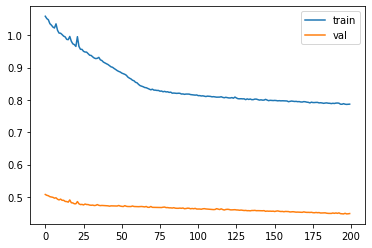

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

**CUSTOM ACCURACY**

In [102]:
test = multi_window.test
y_predict = multi_resnet_lstm_model.predict(test)
multi_resnet_lstm_model.evaluate(test)

7/7 [==============================] - 0s 7ms/step - loss: 0.3560 - mean_absolute_error: 0.3881


[0.35604429244995117, 0.38808196783065796]

72

In [103]:
y_test = []
data = x_test[output_features]
data = np.array(data, dtype=np.float32)
# data = data[7:,:]
data = data[30:,:]
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                data=data,
                targets=None,
                sequence_length=30,
                sequence_stride=1,
                shuffle=False,
                batch_size=len(data))
for i in ds:
    y_test.append(np.array(i))
y_test = np.concatenate(y_test)

In [ ]:
len(data)

261

In [48]:
len(y_predict)

203

In [40]:
std = np.array(std)[2]
mean = np.array(mean)[2]

In [ ]:
print(len(y_test))
len(y_predict)

232


203

In [ ]:
y_predict


In [104]:
# y_true and y_predict has been inverted

def custome_accuracy(y_true, y_predict, feature ,bias=0.1,shift =29):
    index_col = indices_output_features[feature]
    y_true = y_true[:,shift,index_col]
    y_predict = y_predict[:,shift,index_col]
    # print(len(y_true))
    return np.mean(np.abs((y_true-y_predict)/y_true)<=bias)

In [105]:
print("{} : {}".format(output_features[0],custome_accuracy(y_test[29:] * std + mean,y_predict * std + mean,output_features[0])))

All_Non-Routine : 0.009852216748768473


In [68]:
print(len(y_test))
print(len(y_predict))

232
203


In [69]:
y_test.shape

(232, 30, 1)

In [106]:
def create_y_test(y_test):
    construct_y_test = []
    for i in range(len(y_test)):
        construct_y_test.append(y_test[i])
    for i in y_test[-1][1:]:
        construct_y_test.append(i)
    return construct_y_test

In [111]:
y_test_ = create_y_test(y_test)
y_predict_ = create_y_test(y_predict)

In [ ]:
y_predict_

In [113]:
def custom_accuracy_0(y_true, y_predict ,bias=0.2,shift = 29):
    res = []
    for i in range(len(y_predict)):
      res.append(np.abs((y_true[i + shift]-y_predict[i])/y_true[i + shift]) <= bias)  
    return np.mean(res)

In [115]:
custom_accuracy_0(y_test_,y_predict_[2])

0.148